<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

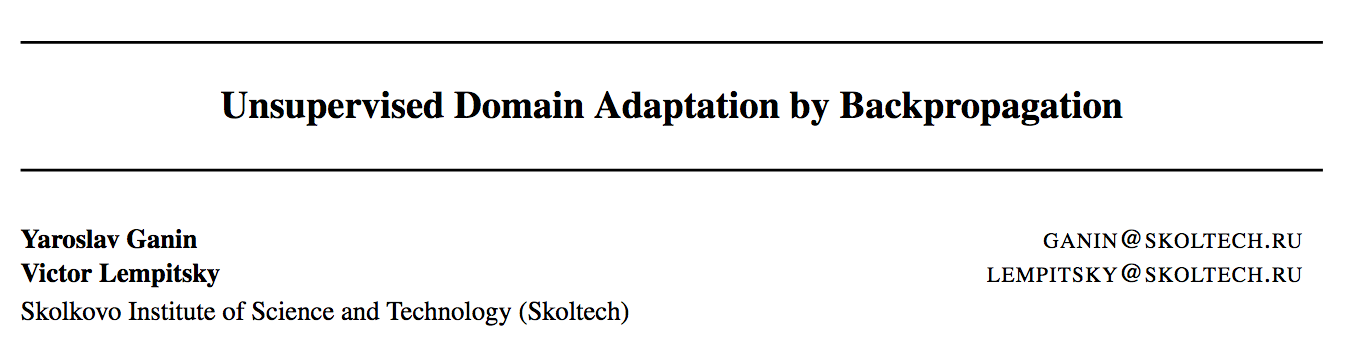

In [46]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f', 'std', 'mean', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [47]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [48]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-12-21 16:17:32--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2821 (2.8K) [text/plain]
Saving to: ‘mnistm.py.3’

mnistm.py.3         100%[===================>]   2.75K  --.-KB/s    in 0s      

2023-12-21 16:17:32 (40.6 MB/s) - ‘mnistm.py.3’ saved [2821/2821]



In [49]:
from mnistm import create_mnistm

create_mnistm()

Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [50]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [51]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

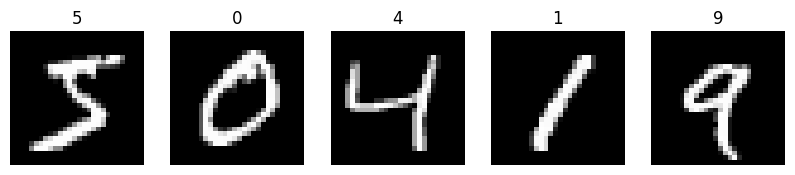

In [52]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [53]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

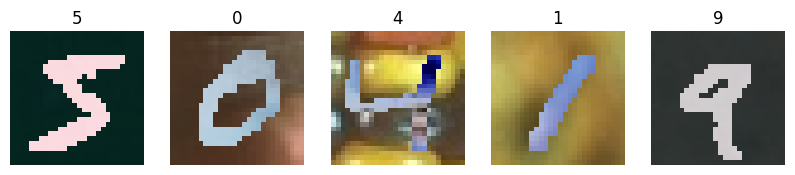

In [54]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

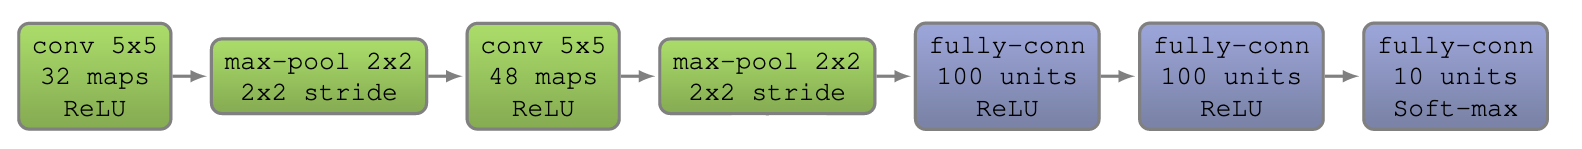

In [55]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3,32,(5,5), stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2, padding = 0),
        nn.Conv2d(32,48,(5,5), stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2)
        )

    self.classif = nn.Sequential(
        nn.Linear(48*7*7,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )

  def forward(self, x):
    nb_batch = x.shape[0]
    x = self.cnn(x)
    x = self.classif(x.view(nb_batch,-1))
    return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

torch.Size([2, 10])

In [56]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification.

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [ ]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 0.23227
	Learning rate = 0.005946035575013606
Epoch 1, train loss: 0.04592
	Learning rate = 0.004386913376508308
Epoch 2, train loss: 0.0297
	Learning rate = 0.0035355339059327372
Epoch 3, train loss: 0.02161
	Learning rate = 0.002990697562442441
Epoch 4, train loss: 0.01698
	Learning rate = 0.0026084743001221454
Epoch 5, train loss: 0.01374
	Learning rate = 0.002323680802425408
Epoch 6, train loss: 0.01146
	Learning rate = 0.0021022410381342864
Epoch 7, train loss: 0.00979
	Learning rate = 0.0019245008972987524
Epoch 8, train loss: 0.00847
	Learning rate = 0.0017782794100389228
Epoch 9, train loss: 0.00742
	Learning rate = 0.0016556002607617019
Test loss: 0.02826, test acc: 99.16


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.53648, test acc: 56.25


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

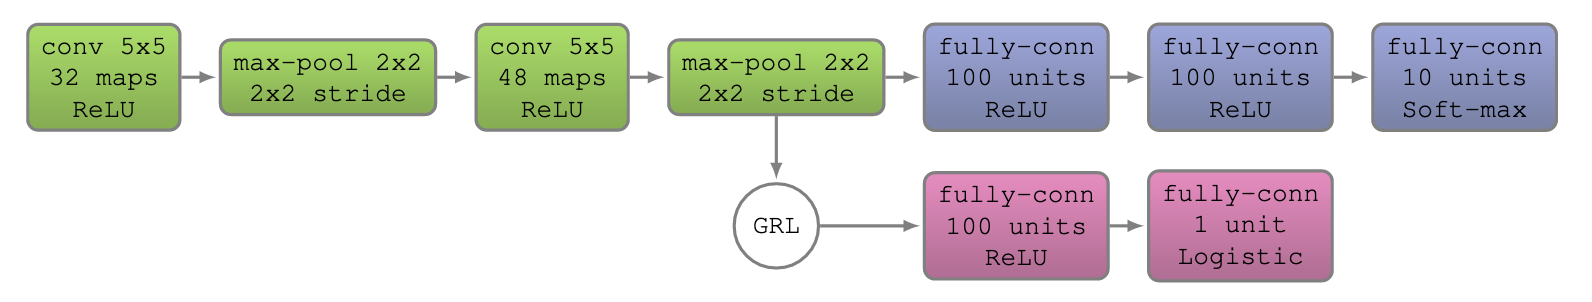

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [57]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = factor * grad

    return reversed_grad, None

In [58]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

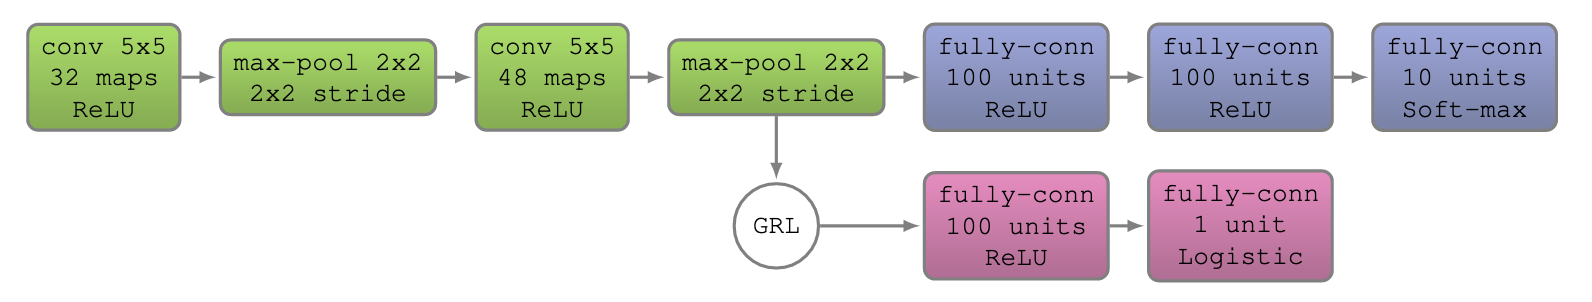

In [59]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3,32,(5,5), stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2),
        nn.Conv2d(32,48,(5,5), stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2)
        )

    self.classif = nn.Sequential(
        nn.Linear(48*7*7,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )

    self.domain = nn.Sequential(
        nn.Linear(48*7*7,100),
        nn.ReLU(),
        nn.Linear(100,1),
        nn.Sigmoid()
    )

  def forward(self, x, factor=1):
    nb_batch = x.shape[0]
    f =  self.cnn(x)
    f = f.view(nb_batch,-1)
    class_pred = self.classif(f)
    domain_pred = self.domain(GradientReversal.apply(f, -1 * factor))
    return class_pred, domain_pred


In [60]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [61]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

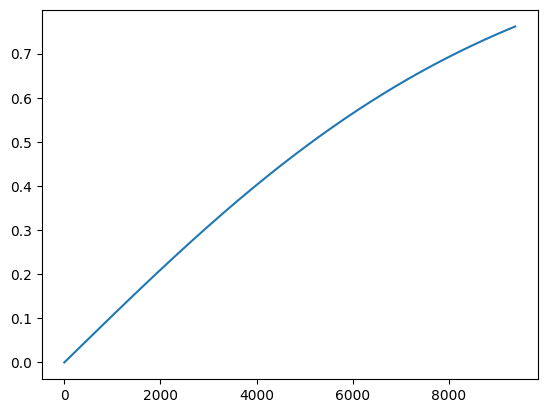

In [18]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [ ]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.2479, domain loss: 0.06923
GRL factor 0.049958374957880025
Epoch 1, class loss: 0.04918, domain loss: 0.05428
GRL factor 0.0996679946249559
Epoch 2, class loss: 0.03127, domain loss: 0.07534
GRL factor 0.14888503362331806
Epoch 3, class loss: 0.02509, domain loss: 0.08797
GRL factor 0.197375320224904
Epoch 4, class loss: 0.02197, domain loss: 0.0973
GRL factor 0.2449186624037092
Epoch 5, class loss: 0.02551, domain loss: 0.12186
GRL factor 0.2913126124515908
Epoch 6, class loss: 0.03168, domain loss: 0.1478
GRL factor 0.3363755443363323
Epoch 7, class loss: 0.22125, domain loss: 0.88417
GRL factor 0.379948962255225
Epoch 8, class loss: 0.05885, domain loss: 0.20968
GRL factor 0.4218990052500078
Epoch 9, class loss: 0.06348, domain loss: 0.15761
GRL factor 0.4621171572600098
Epoch 10, class loss: 0.04643, domain loss: 0.19707
GRL factor 0.5005202111902354
Epoch 11, class loss: 0.05542, domain loss: 0.24651
GRL factor 0.5370495669980351
Epoch 12, cla

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [62]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [18]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

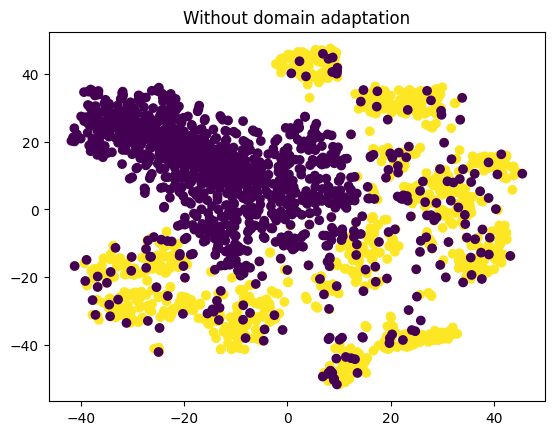

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

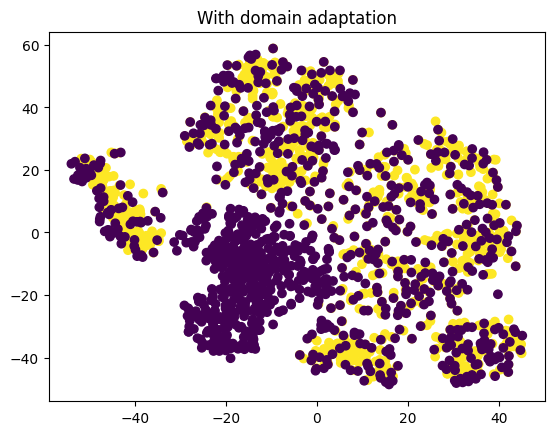

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

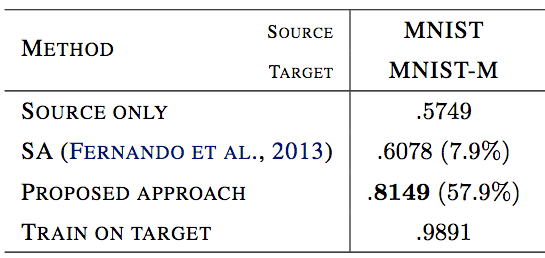

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling

## Without GRL module

In [63]:
class DANN_no_GRL(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(
        nn.Conv2d(3,32,(5,5), stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2),
        nn.Conv2d(32,48,(5,5), stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2)
        )

    self.classif = nn.Sequential(
        nn.Linear(48*7*7,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )

    self.domain = nn.Sequential(
        nn.Linear(48*7*7,100),
        nn.ReLU(),
        nn.Linear(100,1),
        nn.Sigmoid()
    )

  def forward(self, x, factor=1):
    nb_batch = x.shape[0]
    f =  self.cnn(x)
    f = f.view(nb_batch,-1)
    class_pred = self.classif(f)
    domain_pred = self.domain(f)
    return class_pred, domain_pred


In [ ]:
epochs = 20

dann = DANN_no_GRL().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: 1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

Epoch 0, class loss: 0.22383, domain loss: 0.01281
Epoch 1, class loss: 0.04657, domain loss: 0.00069
Epoch 2, class loss: 0.02867, domain loss: 0.0003
Epoch 3, class loss: 0.02027, domain loss: 0.00017
Epoch 4, class loss: 0.01544, domain loss: 0.0001
Epoch 5, class loss: 0.01192, domain loss: 6e-05
Epoch 6, class loss: 0.00935, domain loss: 5e-05
Epoch 7, class loss: 0.00736, domain loss: 4e-05
Epoch 8, class loss: 0.00596, domain loss: 3e-05
Epoch 9, class loss: 0.00497, domain loss: 3e-05
Epoch 10, class loss: 0.00418, domain loss: 2e-05
Epoch 11, class loss: 0.00355, domain loss: 2e-05
Epoch 12, class loss: 0.00301, domain loss: 2e-05
Epoch 13, class loss: 0.0026, domain loss: 2e-05
Epoch 14, class loss: 0.00224, domain loss: 2e-05
Epoch 15, class loss: 0.00198, domain loss: 2e-05
Epoch 16, class loss: 0.00177, domain loss: 1e-05
Epoch 17, class loss: 0.00159, domain loss: 1e-05
Epoch 18, class loss: 0.00145, domain loss: 1e-05
Epoch 19, class loss: 0.00132, domain loss: 1e-05
[SO

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

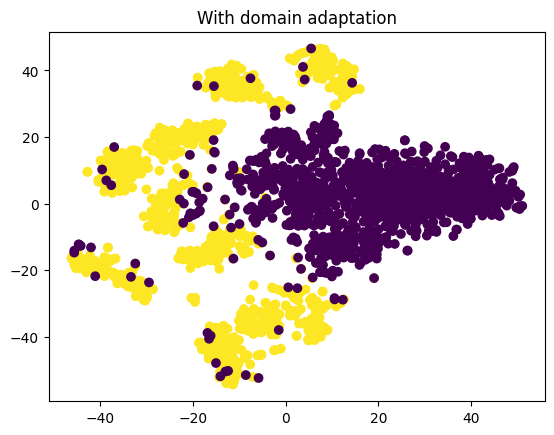

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

## Different gradient factor : linéaire croissante

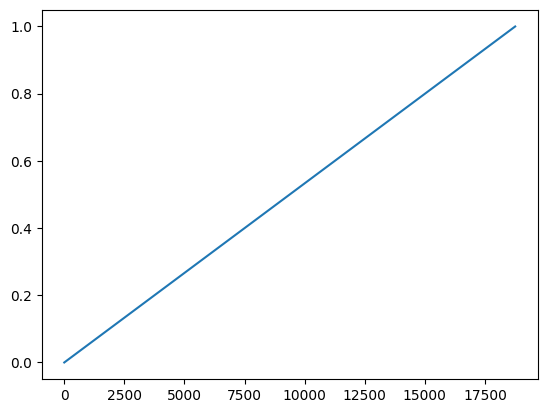

In [30]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: max(0, e / (len(source_train_loader) * epochs)) ## croissance linéaire
y = [lmbd(i) for i in x]

plt.plot(x, y)

20 epochs

In [36]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: max(0, e / (len(source_train_loader) * epochs)) ## croissance linéaire

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0
Epoch 0, class loss: 0.24883, domain loss: 0.08791
GRL factor 0.05
Epoch 1, class loss: 0.0478, domain loss: 0.0603
GRL factor 0.1
Epoch 2, class loss: 0.03134, domain loss: 0.08388
GRL factor 0.15
Epoch 3, class loss: 0.0256, domain loss: 0.09962
GRL factor 0.2
Epoch 4, class loss: 0.02331, domain loss: 0.11161
GRL factor 0.25
Epoch 5, class loss: 0.02627, domain loss: 0.13531
GRL factor 0.3
Epoch 6, class loss: 0.18184, domain loss: 0.798
GRL factor 0.35
Epoch 7, class loss: 0.07173, domain loss: 0.12242
GRL factor 0.4
Epoch 8, class loss: 0.03782, domain loss: 0.16373
GRL factor 0.45
Epoch 9, class loss: 0.0546, domain loss: 0.23093
GRL factor 0.5
Epoch 10, class loss: 0.04695, domain loss: 0.24355
GRL factor 0.55
Epoch 11, class loss: 0.03856, domain loss: 0.27427
GRL factor 0.6
Epoch 12, class loss: 0.04528, domain loss: 0.24186
GRL factor 0.65
Epoch 13, class loss: 0.02769, domain loss: 0.27066
GRL factor 0.7
Epoch 14, class loss: 0.03178, domain loss: 0.25038
GRL fa

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

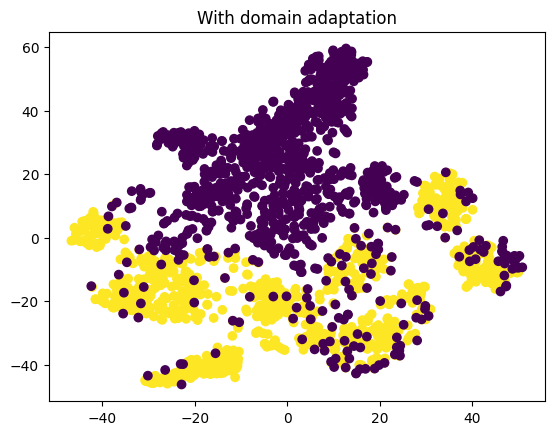

In [37]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

40 epochs

In [44]:
epochs = 40

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: max(0, e / (len(source_train_loader) * epochs)) ## croissance linéaire

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0
Epoch 0, class loss: 0.24446, domain loss: 0.07467
GRL factor 0.025
Epoch 1, class loss: 0.0493, domain loss: 0.0331
GRL factor 0.05
Epoch 2, class loss: 0.03082, domain loss: 0.04542
GRL factor 0.075
Epoch 3, class loss: 0.0217, domain loss: 0.05904
GRL factor 0.1
Epoch 4, class loss: 0.01697, domain loss: 0.06794
GRL factor 0.125
Epoch 5, class loss: 0.01438, domain loss: 0.07457
GRL factor 0.15
Epoch 6, class loss: 0.01249, domain loss: 0.08291
GRL factor 0.175
Epoch 7, class loss: 0.01347, domain loss: 0.09871
GRL factor 0.2
Epoch 8, class loss: 0.01647, domain loss: 0.12123
GRL factor 0.225
Epoch 9, class loss: 0.02159, domain loss: 0.14731
GRL factor 0.25
Epoch 10, class loss: 0.03269, domain loss: 0.21119
GRL factor 0.275
Epoch 11, class loss: 0.0411, domain loss: 0.21149
GRL factor 0.3
Epoch 12, class loss: 0.02786, domain loss: 0.19926
GRL factor 0.325
Epoch 13, class loss: 0.02564, domain loss: 0.22167
GRL factor 0.35
Epoch 14, class loss: 0.03043, domain loss: 0

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

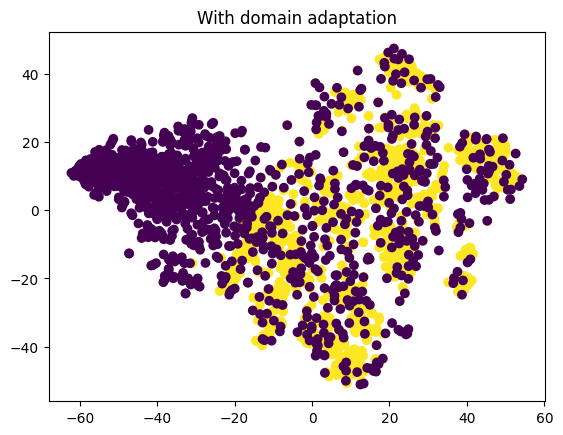

In [45]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

## Different gradient factor: fonction trigonométrique

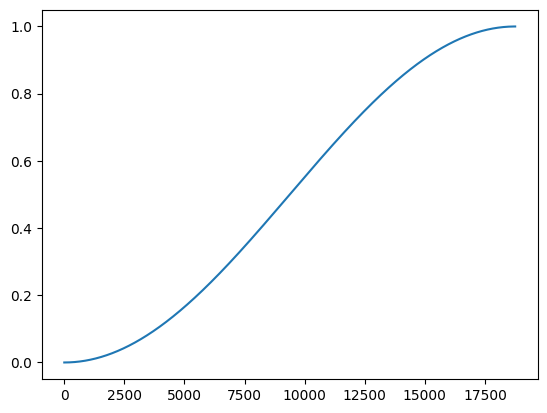

In [34]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: 0.5 * (1 - math.cos(math.pi * e / (len(source_train_loader) * epochs))) #fonction trigonométrique
y = [lmbd(i) for i in x]

plt.plot(x, y)

20 epochs


In [38]:
epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: 0.5 * (1 - math.cos(math.pi * e / (len(source_train_loader) * epochs))) #fonction trigonométrique

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.22871, domain loss: 0.05716
GRL factor 0.006155829702431115
Epoch 1, class loss: 0.04799, domain loss: 0.01381
GRL factor 0.024471741852423234
Epoch 2, class loss: 0.02933, domain loss: 0.03093
GRL factor 0.05449673790581605
Epoch 3, class loss: 0.02103, domain loss: 0.05055
GRL factor 0.09549150281252627
Epoch 4, class loss: 0.01683, domain loss: 0.06524
GRL factor 0.1464466094067262
Epoch 5, class loss: 0.01491, domain loss: 0.08047
GRL factor 0.20610737385376343
Epoch 6, class loss: 0.017, domain loss: 0.09817
GRL factor 0.2730047501302266
Epoch 7, class loss: 0.02081, domain loss: 0.11716
GRL factor 0.3454915028125263
Epoch 8, class loss: 0.02578, domain loss: 0.13608
GRL factor 0.4217827674798845
Epoch 9, class loss: 0.03747, domain loss: 0.16186
GRL factor 0.49999999999999994
Epoch 10, class loss: 0.05646, domain loss: 0.20485
GRL factor 0.5782172325201154
Epoch 11, class loss: 0.06302, domain loss: 0.20578
GRL factor 0.6545084971874737
Epoch

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

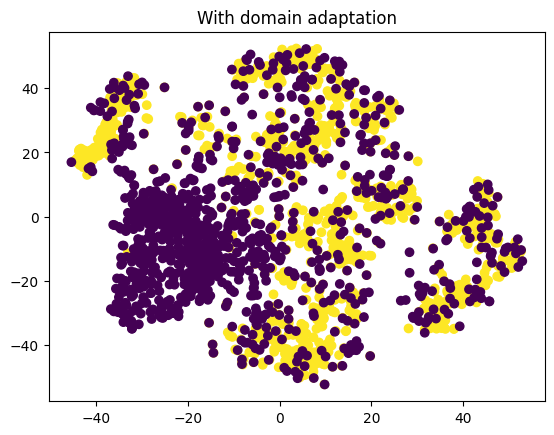

In [39]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

40 epochs

In [64]:
epochs = 40

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: 0.5 * (1 - math.cos(math.pi * e / (len(source_train_loader) * epochs))) #fonction trigonométrique

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.22627, domain loss: 0.03439
GRL factor 0.001541333133436018
Epoch 1, class loss: 0.04882, domain loss: 0.01411
GRL factor 0.006155829702431115
Epoch 2, class loss: 0.02935, domain loss: 0.00898
GRL factor 0.013815039801161721
Epoch 3, class loss: 0.02019, domain loss: 0.00728
GRL factor 0.024471741852423234
Epoch 4, class loss: 0.01451, domain loss: 0.00673
GRL factor 0.03806023374435663
Epoch 5, class loss: 0.01182, domain loss: 0.02148
GRL factor 0.05449673790581605
Epoch 6, class loss: 0.00947, domain loss: 0.02971
GRL factor 0.07367991782295391
Epoch 7, class loss: 0.00744, domain loss: 0.03088
GRL factor 0.09549150281252627
Epoch 8, class loss: 0.00642, domain loss: 0.03964
GRL factor 0.11979701719998453
Epoch 9, class loss: 0.00596, domain loss: 0.05326
GRL factor 0.1464466094067262
Epoch 10, class loss: 0.00587, domain loss: 0.06079
GRL factor 0.17527597583490817
Epoch 11, class loss: 0.00704, domain loss: 0.07148
GRL factor 0.20610737385376

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

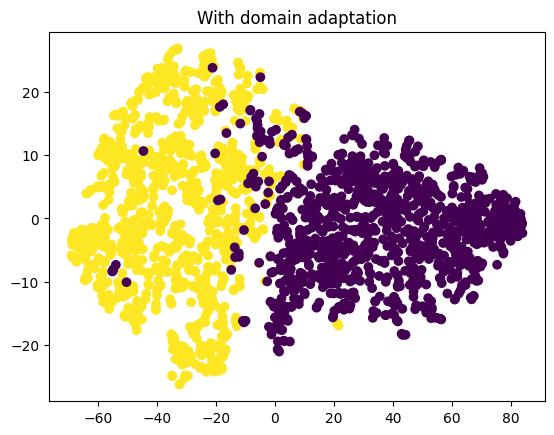

In [65]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

## Increase number of epochs

In [20]:
epochs = 40

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = nn.CrossEntropyLoss()(cls_logits[:len(xs)] , ys )

    bce =nn.BCELoss()(domain_logits.view(-1) , torch.cat((torch.ones(len(xs)),torch.zeros(len(xt)))).cuda())
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 0.24415, domain loss: 0.03799
GRL factor 0.024994792968420665
Epoch 1, class loss: 0.04996, domain loss: 0.03391
GRL factor 0.049958374957880025
Epoch 2, class loss: 0.03128, domain loss: 0.05286
GRL factor 0.0748596906874992
Epoch 3, class loss: 0.02273, domain loss: 0.06479
GRL factor 0.0996679946249559
Epoch 4, class loss: 0.01798, domain loss: 0.07405
GRL factor 0.12435300177159614
Epoch 5, class loss: 0.01493, domain loss: 0.08044
GRL factor 0.14888503362331806
Epoch 6, class loss: 0.01378, domain loss: 0.08697
GRL factor 0.17323515783466026
Epoch 7, class loss: 0.01421, domain loss: 0.1011
GRL factor 0.197375320224904
Epoch 8, class loss: 0.0166, domain loss: 0.11925
GRL factor 0.22127846789844408
Epoch 9, class loss: 0.02449, domain loss: 0.14304
GRL factor 0.2449186624037092
Epoch 10, class loss: 0.02679, domain loss: 0.15926
GRL factor 0.2682711820216015
Epoch 11, class loss: 0.03443, domain loss: 0.17153
GRL factor 0.2913126124515908
Epoch 

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

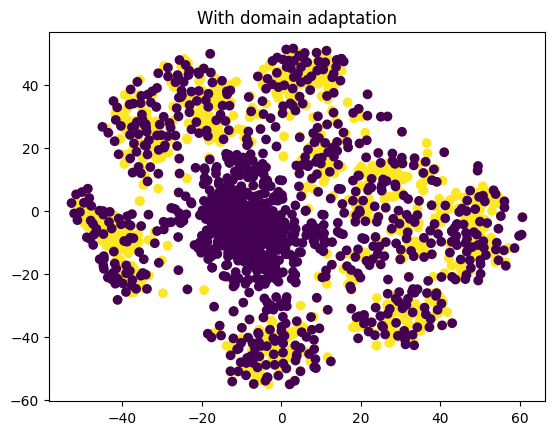

In [21]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")